**The flow of the Notebook:**

1. Description of the Problem Statement.

2. Car Damage Detection Dataset Loading.

3. Check The Dataset.

4. Split The Dataset in Train, Test and Validation Set.

5. Apply Data Augmentation.

6. Hyper Parameter Tuning, and verification for improving the performance.

7. Training the Model. (Tyre Classification Custom Model Implementation using Tensorflow Functional API)

8. Save the trained model.

9. Visualize Tensorboard.

10. Check Performance of the Model.

11. Model Evaluation (Confusion Matrix, Classification Report, TP,FP,TN,FN,Precision, Recall and F1-Score, Precision-Recall Curve,ROC and AUC Curve).

12. Convert Tensorflow model into ONNX format and TF Lite format Then compare the compressed models file size, Inference Time and Accuracy.(model inference lightening and speeding for implementation on Edge Device)

13. Apply Basic FastAPI Technique.

14. MLOps: Apply Basic MLFlow Technique for model tracking.  


**Problem Statement:**
Flat tyres doesn't have enough air pressure so they are flat. These tyres need to be filled again and checked or else it may become the very reason of an accident.

**Import Libraries**

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping,LearningRateScheduler,CSVLogger, ModelCheckpoint
from sklearn.metrics import confusion_matrix ,classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

**DEFINE IMAGE SIZE, BATCH SIZE and NUMBER OF CHNNELS**

In [6]:
IMAGE_SIZE = 100
BATCH_SIZE = 32
CHANNELS = 3

**Tyre Classification Data Set Loading**

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/tire-dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    #color_mode = "grayscale"
)

Found 900 files belonging to 3 classes.


**SHOW THE CLASS NAMES**

In [8]:
class_names = dataset.class_names
class_names

['flat', 'full', 'no-tire']

**CHECK THE BATCH SIZE, IMAGE SIZE , NUMBER OF CHANNELS and LABELS**

In [9]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 100, 100, 3)
[1 2 2 2 0 1 2 1 0 1 0 0 1 1 2 2 0 0 1 1 2 2 1 0 2 0 0 0 1 2 0 2]


**CHECK THE IMAGE DATA**

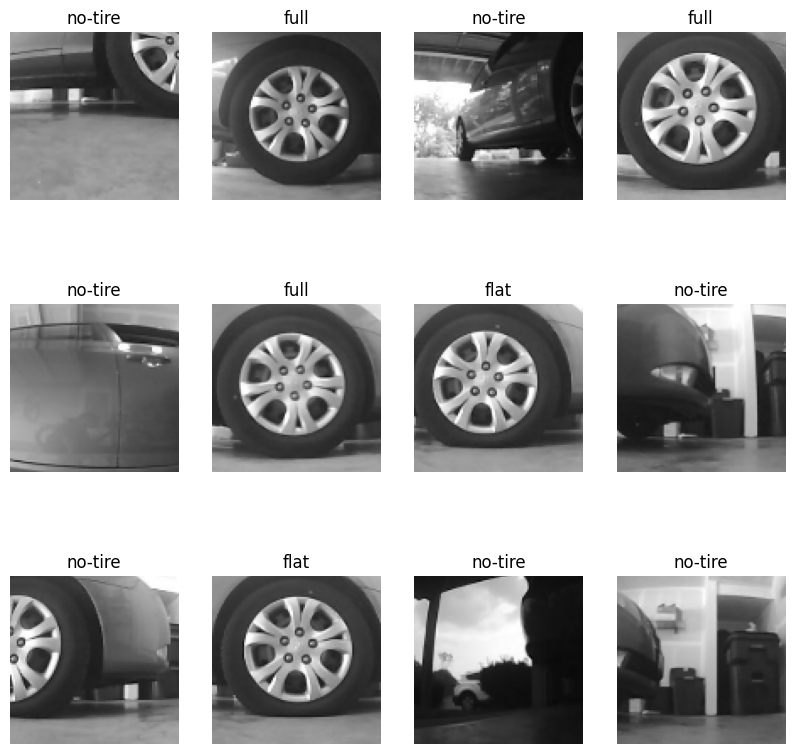

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

**SPLIT THE DATA SET INTO TRAIN, VALIDATION and TEST**

In [11]:
def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=900):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds



In [12]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [ ]:
len(train_ds)

23

In [ ]:
len(val_ds)

2

In [ ]:
len(test_ds)

4

**Apply DATA AUGMENTATION**

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for data augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    #rescale=1.0 / 255  # Rescale pixel values to [0, 1]
)

# Extract images and labels from the training dataset
train_images = []
train_labels = []
for images_batch, labels_batch in train_ds:
    train_images.append(images_batch.numpy())
    train_labels.append(labels_batch.numpy())
train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)

# Apply data augmentation to the training dataset
augmented_train_ds = data_augmentation.flow(
    x=train_images,
    y=train_labels,  # You need to specify the labels as well
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123
)

# Apply rescaling to the validation and test datasets
#val_ds = val_ds.map(lambda x, y: (x / 255, y))
#test_ds = test_ds.map(lambda x, y: (x / 255, y))

**Apply rescaling to the Train, validation and test datasets**

In [ ]:
train_ds = train_ds.map(lambda x, y: (x / 255, y))
val_ds = val_ds.map(lambda x, y: (x / 255, y))
test_ds = test_ds.map(lambda x, y: (x / 255, y))

**APPLY CACHE and PREFETCH FOR SPEEDING UP DATA PROCESSING PIPELINE**

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**DEFINE THE NUMBER OF CLASS**

In [15]:
number_of_class = len(class_names)
print(number_of_class)

3


**Tyre Classification Custom Model Architecture**

In [68]:
def custom_model(input_shape, number_of_class,activation):
# Define the input layer
  input_layer = tf.keras.Input(shape=input_shape)

  # Define the layers as functional components
  conv_1 = layers.Conv2D(filters=32,kernel_size= (3, 3), activation='relu')(input_layer)
  max_pool_1 = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(conv_1)
  drop_out_1 = layers.Dropout(0.3)(max_pool_1)
  conv_2 = layers.Conv2D(filters=16,kernel_size= (3, 3), activation='relu')(drop_out_1)
  max_pool_2 = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(conv_2)
  flatten = layers.Flatten()(max_pool_2)
  dense = layers.Dense(units=64,activation='relu')
  drop_out_2 = layers.Dropout(0.3)(flatten)
  output_layer = layers.Dense(units=number_of_class,activation=activation)(drop_out_2)  # Corrected to match the number of classes

# Create the functional API model
  model = models.Model(inputs=input_layer, outputs=output_layer)
  return model

input_shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
number_of_class = number_of_class
activation='softmax'
custom_model = custom_model(input_shape,number_of_class,activation)

custom_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 49, 49, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 47, 47, 16)        4624      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 24, 24, 16)       0         
 2D)                                                       

**COMPILE Tyre Classification Custom Model Architecture**

In [69]:
custom_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

**DEFINE Tyre Classification Custom Model LOG DIRECTORY**

In [70]:
log_dir='logs_custom_model'

**Define Learning Rate Scheduler Callback**

In [71]:
# Define the learning rate schedule using a cosine annealing function
def cosine_annealing(epoch, lr):
    max_epochs = 10  # Total number of epochs
    max_lr = 0.01  # Maximum learning rate
    min_lr = 0.001  # Minimum learning rate

    # Apply cosine annealing formula
    lr = min_lr + 0.5 * (max_lr - min_lr) * (1 + tf.math.cos(epoch / max_epochs * np.pi))
    return lr

lr_scheduler_callback = LearningRateScheduler(cosine_annealing)

**DEFINE EARLY STOPPING CALL BACK**

In [72]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=3,  # Stop training if validation accuracy doesn't improve for 3 epochs
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

**DEFINE CSV LOGGER CALL BACK**

In [73]:
csv_logger = CSVLogger(
    filename=log_dir + '/training_log.csv',  # Specify the CSV file path
    separator=',',  # Separator used in the CSV file
    append=False  # Append to the existing file if it exists
)

**DEFINE CHECK POINT CALL BACK**

In [74]:
# Create the ModelCheckpoint callback
checkpoint_path = log_dir + '/best_custom_model.h5'
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",  # Choose the metric to monitor for saving the best model
    save_best_only=True,
    mode="max",  # Choose "max" if your metric should be maximized, "min" if minimized
    verbose=1
)

**DEFINE TENSORBOARD CALL BACK**

In [75]:
# Define the TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

**Tyre Classification Custom Model TRAINING**

In [76]:
EPOCHS = 100
custom_model_history = custom_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[lr_scheduler_callback,early_stopping,csv_logger,checkpoint_callback,tensorboard_callback]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


23/23 [==============================] - ETA: 0s - loss: 86.3819 - accuracy: 0.3701
Epoch 1: val_accuracy improved from -inf to 0.34375, saving model to logs_custom_model/best_custom_model.h5
23/23 [==============================] - 12s 477ms/step - loss: 86.3819 - accuracy: 0.3701 - val_loss: 1.0985 - val_accuracy: 0.3438 - lr: 0.0100
Epoch 2/100
23/23 [==============================] - ETA: 0s - loss: 1.0987 - accuracy: 0.3362
Epoch 2: val_accuracy did not improve from 0.34375
23/23 [==============================] - 9s 394ms/step - loss: 1.0987 - accuracy: 0.3362 - val_loss: 1.0989 - val_accuracy: 0.3438 - lr: 0.0098
Epoch 3/100
23/23 [==============================] - ETA: 0s - loss: 1.0988 - accuracy: 0.3362
Epoch 3: val_accuracy did not improve from 0.34375
23/23 [==============================] - 10s 409ms/step - loss: 1.0988 - accuracy: 0.3362 - val_loss: 1.0997 - val_accuracy: 0.3438 - lr: 0.0091
Epoch 4/100
23/23 [==============================] - ETA: 0s - loss: 1.0986 - acc

**SAVE Tyre Classification Custom Model MODEL**

In [77]:
# Define a path to save the model
model_save_path = "/content/models/custom_model"

# Save the model
custom_model.save(model_save_path)

print("Model saved at:", model_save_path)

Model saved at: /content/models/custom_model


**TENSORBOARD DASBOARD**

In [78]:
%load_ext tensorboard
%tensorboard --logdir logs_custom_model

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-09-06 05:09:33.960971: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.

**EVALUATE Tyre Classification Custom Model SCORE**

In [79]:
scores = custom_model.evaluate(test_ds)

4/4 [==============================] - 0s 102ms/step - loss: 1.0988 - accuracy: 0.3203


In [80]:
custom_model_history.params

{'verbose': 1, 'epochs': 100, 'steps': 23}

In [81]:
custom_model_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

**PLOAT ACCURACY and LOSS CURVE**

In [82]:
acc = custom_model_history.history['accuracy']
val_acc = custom_model_history.history['val_accuracy']

loss = custom_model_history.history['loss']
val_loss = custom_model_history.history['val_loss']

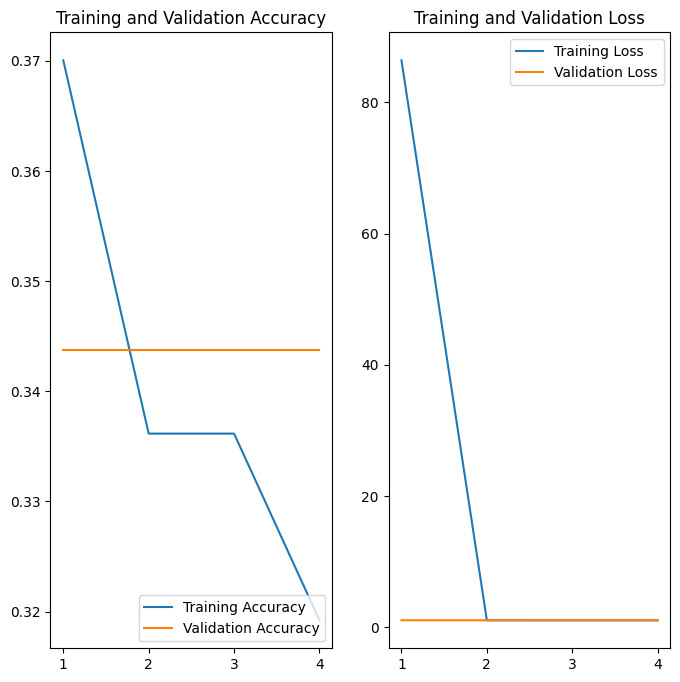

In [83]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(acc) + 1), acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**SINGLE PREDICTION**

first image to predict
actual label: no-tire
1/1 [==============================] - 0s 182ms/step
predicted label: no-tire


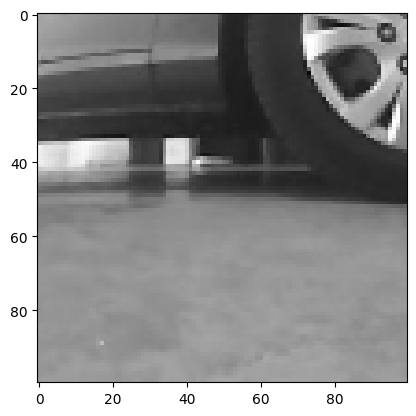

In [84]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = custom_model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

**WRITE A FUNCTION FOR INFERENCE**

In [85]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = custom_model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**RUN INFERENCE ON FEW TEST IMAGES**

1/1 [==============================] - 0s 32ms/step


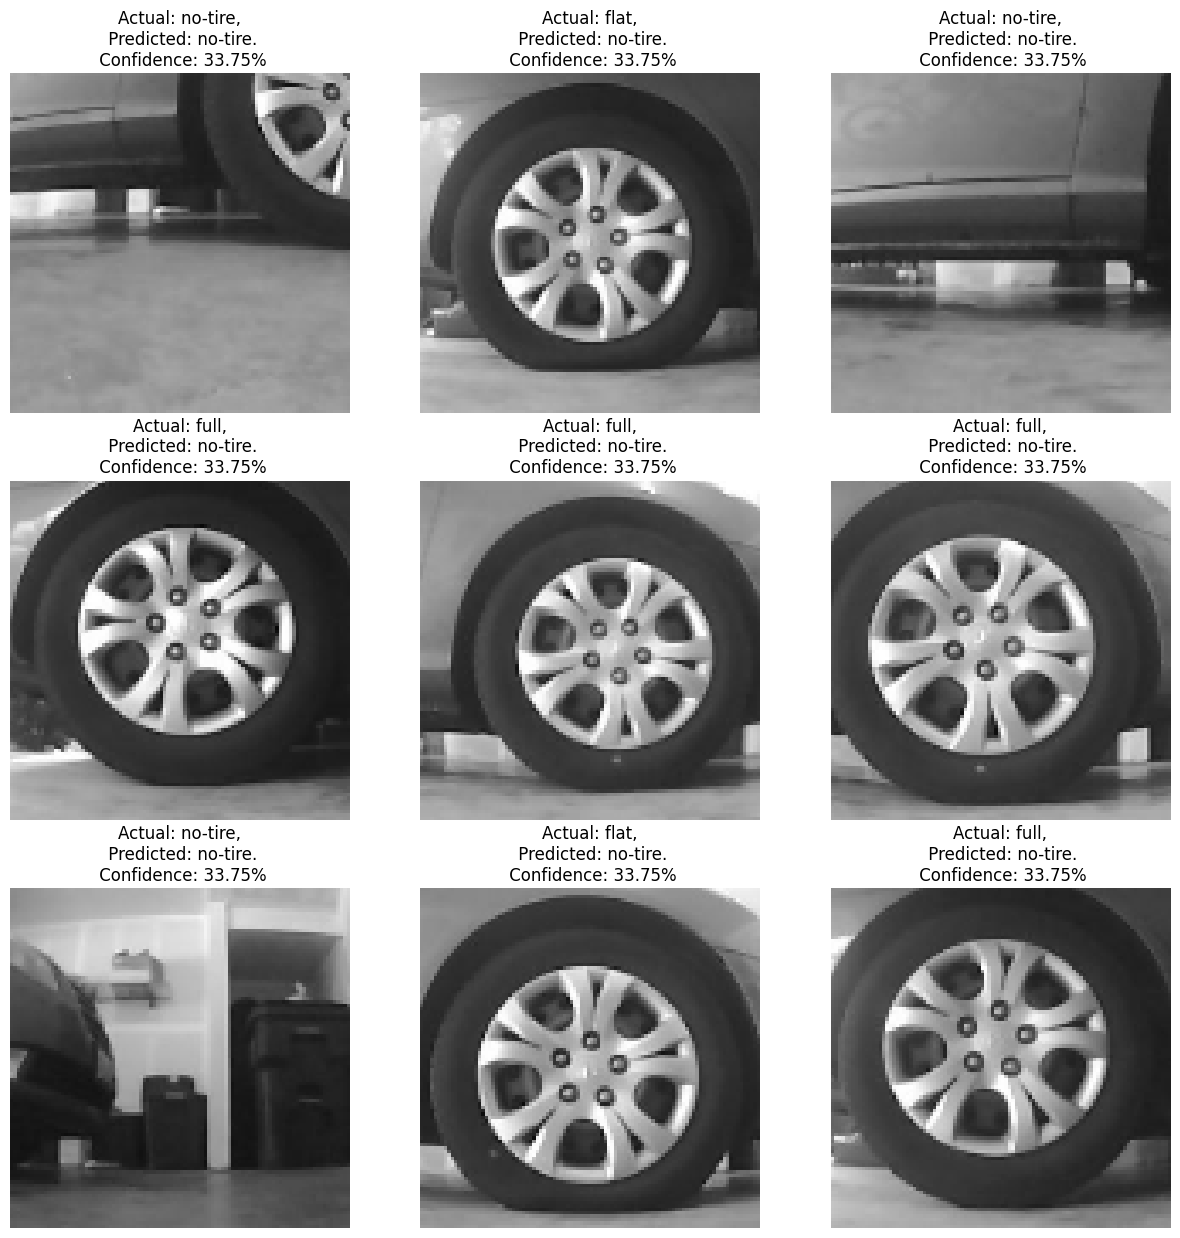

In [86]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(custom_model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

**MODEL EVALUATION and VERIFICATION**

4/4 [==============================] - 1s 188ms/step


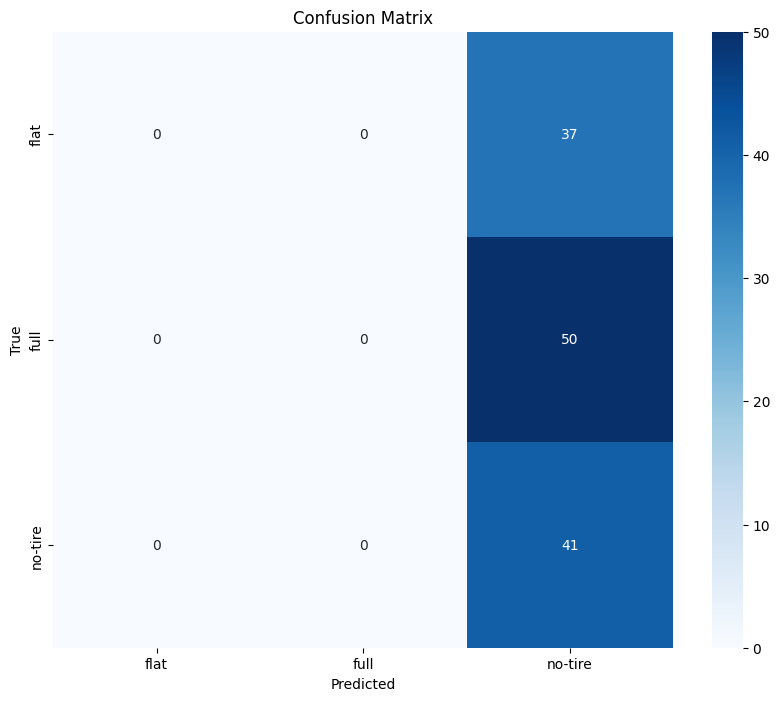

True Positives (TP): 0
False Positives (FP): 0
True Negatives (TN): 0
False Negatives (FN): 0
Recall (Sensitivity): nan
              precision    recall  f1-score   support

        flat       0.00      0.00      0.00        37
        full       0.00      0.00      0.00        50
     no-tire       0.32      1.00      0.49        41

    accuracy                           0.32       128
   macro avg       0.11      0.33      0.16       128
weighted avg       0.10      0.32      0.16       128



<ipython-input-87-53c1a2dddcc1>:33: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp / (tp + fn)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [87]:
# Generate predictions for the test dataset
test_images = []
test_labels = []
for images_batch, labels_batch in test_ds:
    test_images.extend(images_batch.numpy())
    test_labels.extend(labels_batch.numpy())

test_images = np.array(test_images)
test_labels = np.array(test_labels)

predictions = custom_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Calculate TP, FP, TN, FN
tp = conf_matrix[1, 1]
fp = conf_matrix[0, 1]
tn = conf_matrix[0, 0]
fn = conf_matrix[1, 0]

# Calculate Recall (Sensitivity)
recall = tp / (tp + fn)

# Print the metrics
print("True Positives (TP):", tp)
print("False Positives (FP):", fp)
print("True Negatives (TN):", tn)
print("False Negatives (FN):", fn)
print("Recall (Sensitivity):", recall)

# Classification Report
class_report = classification_report(test_labels, predicted_labels, target_names=class_names)
print(class_report)

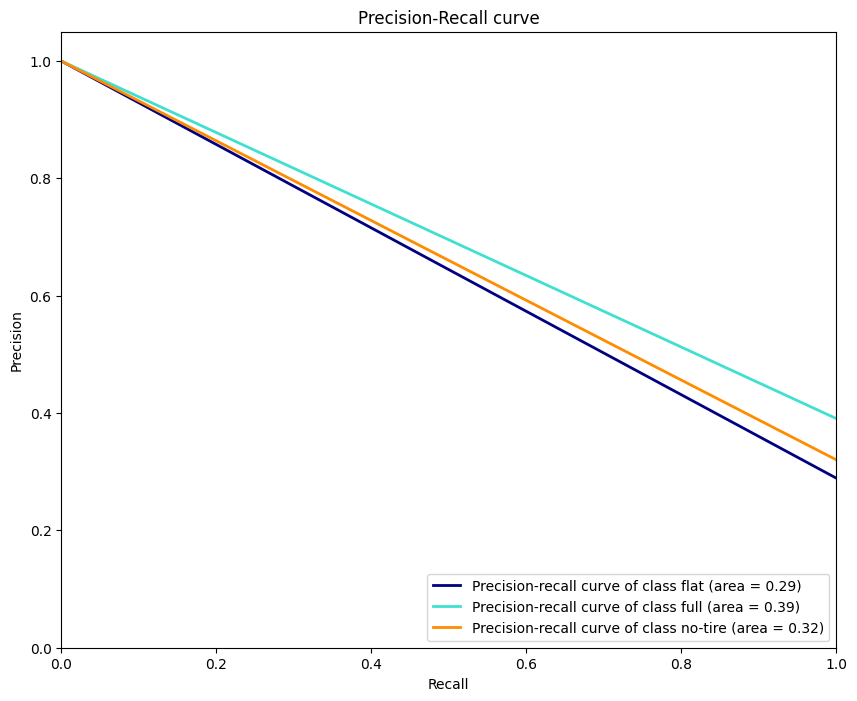

In [88]:
# Calculate precision-recall curves and average precision
precision = dict()
recall = dict()
average_precision = dict()
for i in range(number_of_class):
    precision[i], recall[i], _ = precision_recall_curve(test_labels == i, predictions[:, i])
    average_precision[i] = average_precision_score(test_labels == i, predictions[:, i])

# Plot precision-recall curves
plt.figure(figsize=(10, 8))
colors = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal']
for i, color in zip(range(number_of_class), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Precision-recall curve of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()


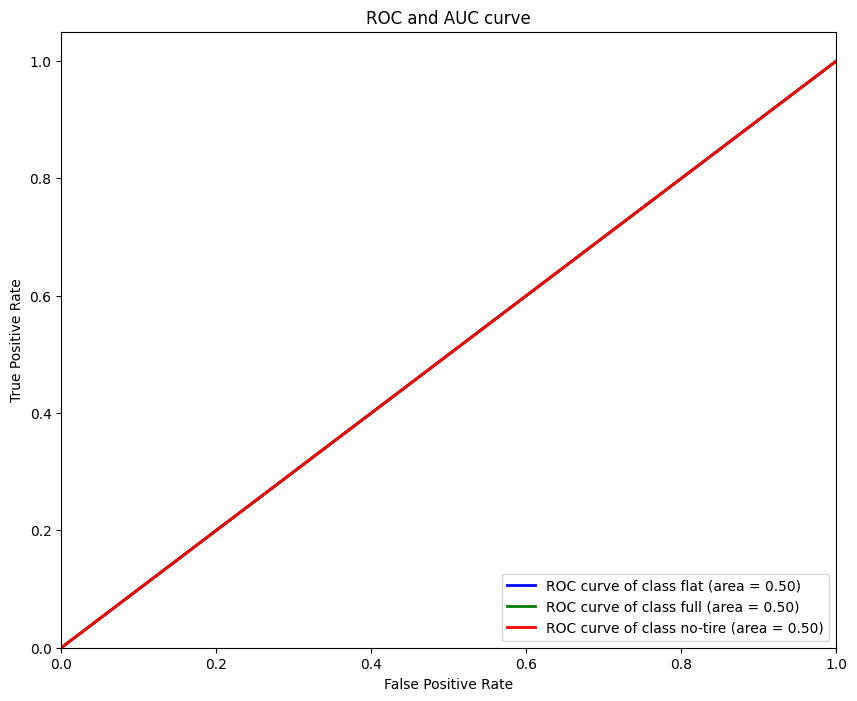

In [89]:
# Calculate ROC curves and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(number_of_class):
    fpr[i], tpr[i], _ = roc_curve(test_labels == i, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'cyan', 'magenta']
for i, color in zip(range(number_of_class), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC and AUC curve')
plt.legend(loc="lower right")
plt.show()

**Convert Tensorflow model into ONNX format and TF Lite format Then compare the compressed models file size, Inference Time and Accuracy:(model inference lightening and speeding for implementation on Edge Device)**

In [90]:
!pip install tf2onnx
!pip install onnx
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.7/454.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.1 MB/s eta 0:00:00


Model File Sizes:
TensorFlow Model Size: 0.38756752014160156 MB
TensorFlow Lite Model Size: 0.12932205200195312 MB
ONNX Model Size: 0.12868404388427734 MB
<<<<<<<<<<<=========================================>>>>>>>>>>>
1/1 [==============================] - 0s 77ms/step
Inference Times:
TensorFlow Inference Time: 0.12879514694213867 seconds
TensorFlow Lite Inference Time: 0.002247333526611328 seconds
ONNX Inference Time: 0.002055644989013672 seconds
<<<<<<<<<<<=========================================>>>>>>>>>>>
<<<<<<<<<<<=========================================>>>>>>>>>>>
Predicted Label and Confidence:
TensorFlow: no-tire  (Confidence: 33.75%)
TensorFlow Lite: no-tire  (Confidence: 33.75%)
ONNX: no-tire  (Confidence: 33.75%)


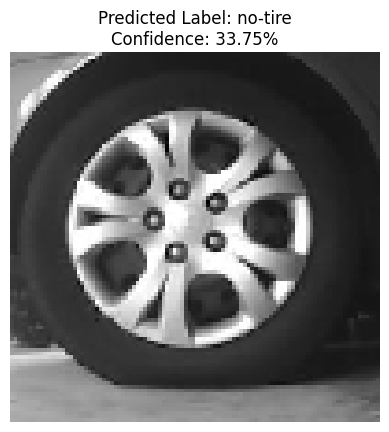

In [92]:
import tensorflow as tf
import tf2onnx
import onnxruntime
import time
import os

def get_file_size(file_path):
    return os.path.getsize(file_path) / (1024 * 1024)  # Convert bytes to MB

def compare_models(saved_model_path, image_path):
    # Load the saved TensorFlow model (SavedModel format)
    tf_model = tf.keras.models.load_model(saved_model_path)

    # Convert the TensorFlow model to TensorFlow Lite format
    tflite_model = tf.keras.models.load_model(saved_model_path)
    converter = tf.lite.TFLiteConverter.from_keras_model(tflite_model)
    tflite_model = converter.convert()

    # Convert the TensorFlow model to ONNX format
    onnx_model, _ = tf2onnx.convert.from_keras(tf_model)

    # Save the TensorFlow Lite model to a file
    tflite_model_path = 'Tyre_Classification_Custom_Model.tflite'
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)

    # Save the ONNX model to a file
    onnx_model_path = 'Tyre_Classification_Custom_Model.onnx'
    with open(onnx_model_path, 'wb') as f:
        f.write(onnx_model.SerializeToString())

    # Get model file sizes
    file_size = "/content/models/custom_model/variables/variables.data-00000-of-00001"
    tf_model_size = get_file_size(file_size)
    tflite_model_size = get_file_size(tflite_model_path)
    onnx_model_size = get_file_size(onnx_model_path)

    print("Model File Sizes:")
    print("TensorFlow Model Size:", tf_model_size, "MB")
    print("TensorFlow Lite Model Size:", tflite_model_size, "MB")
    print("ONNX Model Size:", onnx_model_size, "MB")
    print("<<<<<<<<<<<=========================================>>>>>>>>>>>")
    # Load and preprocess the single image
    input_shape = tf_model.input_shape[1:3]  # Adjust for your model's input shape
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=input_shape)
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)

    # TensorFlow inference
    tf_start_time = time.time()
    tf_output = tf_model.predict(image_array)
    tf_end_time = time.time()
    tf_inference_time = tf_end_time - tf_start_time

    # TensorFlow Lite inference
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()
    tflite_start_time = time.time()
    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], image_array)
    interpreter.invoke()
    tflite_output = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
    tflite_end_time = time.time()
    tflite_inference_time = tflite_end_time - tflite_start_time

    # ONNX inference
    onnx_session = onnxruntime.InferenceSession(onnx_model_path)
    input_name = onnx_session.get_inputs()[0].name
    onnx_start_time = time.time()
    onnx_output = onnx_session.run(None, {input_name: image_array})
    onnx_end_time = time.time()
    onnx_inference_time = onnx_end_time - onnx_start_time

    print("Inference Times:")
    print("TensorFlow Inference Time:", tf_inference_time, "seconds")
    print("TensorFlow Lite Inference Time:", tflite_inference_time, "seconds")
    print("ONNX Inference Time:", onnx_inference_time, "seconds")
    print("<<<<<<<<<<<=========================================>>>>>>>>>>>")
    # Compare predictions
    class_names = ["flat", "full", "no-tire"]  # Replace with your class names
    tf_predicted_label = np.argmax(tf_output[0])
    tflite_predicted_label = np.argmax(tflite_output[0])
    onnx_predicted_label = np.argmax(onnx_output[0])
    print("<<<<<<<<<<<=========================================>>>>>>>>>>>")
    print("Predicted Label and Confidence:")
    print("TensorFlow:", class_names[tf_predicted_label], " (Confidence: {:.2f}%)".format(tf_output[0][tf_predicted_label] * 100))
    print("TensorFlow Lite:", class_names[tflite_predicted_label], " (Confidence: {:.2f}%)".format(tflite_output[0][tflite_predicted_label] * 100))
    print("ONNX:", class_names[onnx_predicted_label], " (Confidence: {:.2f}%)".format(onnx_output[0][0][onnx_predicted_label] * 100))

    # Display the image with the predicted label and confidence
    import matplotlib.pyplot as plt

    plt.imshow(image)
    plt.title("Predicted Label: {}\nConfidence: {:.2f}%".format(class_names[tf_predicted_label], tf_output[0][tf_predicted_label] * 100))
    plt.axis('off')
    plt.show()

    # Clean up: Delete temporary ONNX and TensorFlow Lite model files
    #os.remove(tflite_model_path)
    #os.remove(onnx_model_path)

# Example usage with a single image
saved_model_path = '/content/models/custom_model'
image_path = '/content/tire-dataset/flat/00000.jpg'

compare_models(saved_model_path, image_path)

**Apply Basic FastAPI Technique:**

In [ ]:
!pip install fastapi
!pip install uvicorn
!pip install python-multipart
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 811.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 570.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=ff4ad07fa8435c89b5f86498a8778fd8b8c9924affb2ca35f2f364228da7883b
  Stored in directory: /root/.cache/pip/wheels/5c/42/78/0c3d438d7f5730451a25f7ac6cbf4391759d22a67576ed7c2c
Successfully built pyngrok


In [ ]:
from fastapi import FastAPI, File, UploadFile
from fastapi.middleware.cors import CORSMiddleware
import uvicorn
from pyngrok import ngrok
import numpy as np
from io import BytesIO
from PIL import Image
import tensorflow as tf

app = FastAPI()

origins = [
    "http://localhost",
    "http://localhost:8000",
]
app.add_middleware(
    CORSMiddleware,
    allow_origins=origins,
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

MODEL = tf.keras.models.load_model("/content/models/custom_model")

CLASS_NAMES = ["flat", "full", "no-tire"]

@app.get("/ping")
async def ping():
    return "Hello, I am alive"

def read_file_as_image(data) -> np.ndarray:
    image = np.array(Image.open(BytesIO(data)))
    return image

@app.post("/predict")
async def predict(
    file: UploadFile = File(...)
):
    image = read_file_as_image(await file.read())
    img_batch = np.expand_dims(image, 0)

    predictions = MODEL.predict(img_batch)

    predicted_class = CLASS_NAMES[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])
    return {
        'class': predicted_class,
        'confidence': float(confidence)
    }

if __name__ == "__main__":
    uvicorn.run(app, host='localhost', port=8000)


# Expose the FastAPI app using ngrok
public_url = ngrok.connect(port=8000)
print("Public URL:", public_url)

# Use Ctrl+C to stop the ngrok tunnel when you're done

**MLOps: Apply Basic MLFlow Technique for model tracking:**

In [ ]:
!pip install mlflow
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.1 MB/s eta 0:00:00
  Created wheel for databricks-cli: filename=databricks_cli-0.17.7-py3-none-any.whl size=143856 sha256=bd363bcd968c4482229b1f3d7f31fde628e70f8d9a2ffda5fa7bae244d90cb83
  Stored in directory: /root/.cache/pip/wheels/ae/63/93/5402c1a09c

In [ ]:
import mlflow
from mlflow import log_metric, log_param, log_artifacts
from pyngrok import ngrok

# Log parameters to MLflow
mlflow.start_run()
log_param("input_shape", input_shape)
log_param("optimizer", "Adam")
log_param("loss_function", "categorical_crossentropy")
log_metric("final_train_accuracy", custom_model_history.history['accuracy'][-1])
log_metric("final_val_accuracy", custom_model_history.history['val_accuracy'][-1])
log_artifacts("/content/models/custom_model")

# Start ngrok to create a tunnel to the MLflow UI
get_ipython().system_raw("mlflow ui --port 8000 &")
get_ipython().system_raw("./ngrok http 8000 &")

# Get the public URL for the MLflow UI using ngrok
import time
time.sleep(2)  # Give ngrok time to start

from urllib.parse import urlparse
from urllib.request import urlopen
import json

# Fetch ngrok public URL
ngrok_url = !curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

# Parse the URL and get the ngrok domain
parsed_url = urlparse(ngrok_url[0])
ngrok_domain = parsed_url.netloc

# Construct the full MLflow UI URL
mlflow_ui_url = f"http://{ngrok_domain}:8000"

print("MLflow UI URL:", mlflow_ui_url)


In [ ]:
mlflow.end_run()

**Zip and Download Model File**

In [ ]:
!zip -r models.zip models/

In [ ]:
from google.colab import files
files.download('models.zip')